In [1]:
import os 
import sys
import shutil
import glob
import importlib
#from pathlib import Path
import random

import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
from pysiib import SIIB

import IPython

repos_dir = r'/home/akikun/repos'
sys.path.append(repos_dir)
from sak import display as dp
from sak import signal_processing as sp
from sak import nele

repos_imgan_dir = os.path.join(repos_dir, 'Intelligibility-MetricGAN')
sys.path.append(repos_imgan_dir)
import default_settings as default
#import audio_util as au

sampling_frequency = 44100

In [2]:
def SIIB_Wrapper(x, y, fs):
    minL = min(len(x), len(y))
    x = x[:minL]
    y = y[:minL]
    M = len(x)/fs
    if(M<20):
        x = np.hstack([x]*round(50/M))
        y = np.hstack([y]*round(50/M))
    #return mapping_func_jr(SIIB(x,y,fs,gauss=True))
    return SIIB(x, y, fs, gauss=True)

    
def read_SIIB(clean_file, noise_file, enhanced_file, sampling_frequency=44100):
    clean_wav    = sp.load_wav(clean_file)     
    noise_wav    = sp.load_wav(noise_file)     
    enhanced_wav = sp.load_wav(enhanced_file)
    
    minL = min(len(clean_wav),len(enhanced_wav))
    clean_wav = clean_wav[:minL]
    noise_wav = noise_wav[:minL]
    enhanced_wav = enhanced_wav[:minL]
    
    siib_score = SIIB_Wrapper(clean_wav, enhanced_wav + noise_wav, sampling_frequency)  
    return siib_score

In [3]:
def siib_ssdrc():
    n_epoch = 1
    imgan_dir = os.path.join(default.output_path, 'epoch' + str(n_epoch), 'Test_epoch' + str(n_epoch))
    wav_imgan_paths = glob.glob(os.path.join(imgan_dir, '*.wav'))

    siib_scores = []
    wav_imgan_paths.sort()
    for i, wav_imgan_path in enumerate(wav_imgan_paths, start=1):
        wav_basename = os.path.basename(wav_imgan_path)

        wav_id = wav_basename.split('_snr')[0] + '.wav'
        snr_str = wav_basename.split('_snr')[1].split('@')[0]
        snr = int(snr_str)

        wav_clean_path = os.path.join(per_snr_dir, 'test', 'clean', wav_id)
        wav_noise_path = os.path.join(per_snr_dir, 'test', 'noise'+snr_str, wav_id)
        wav_ssdrc_path = os.path.join(ssdrc_dir, wav_id)


        # calculate SIIB.    
        print('\r' + '{}/{}'.format(i, len(wav_imgan_paths)), end="")
        siib_score = read_SIIB(wav_clean_path, wav_noise_path, wav_ssdrc_path)

        siib_scores.append([snr, siib_score])
    return pd.DataFrame(siib_scores, columns = ['snr', 'siib'])
    
    
def siib_imgan(n_epoch):
    imgan_dir = os.path.join(default.output_path, 'epoch' + str(n_epoch), 'Test_epoch' + str(n_epoch))
    wav_imgan_paths = glob.glob(os.path.join(imgan_dir, '*.wav'))

    siib_scores = []
    wav_imgan_paths.sort()
    for i, wav_imgan_path in enumerate(wav_imgan_paths, start=1):
        wav_basename = os.path.basename(wav_imgan_path)

        wav_id = wav_basename.split('_snr')[0] + '.wav'
        snr_str = wav_basename.split('_snr')[1].split('@')[0]
        snr = int(snr_str)

        wav_clean_path = os.path.join(per_snr_dir, 'test', 'clean', wav_id)
        wav_noise_path = os.path.join(per_snr_dir, 'test', 'noise'+snr_str, wav_id)
        #wav_ssdrc_path = os.path.join(ssdrc_dir, wav_id)

        print('\r' + '{}/{}'.format(i, len(wav_imgan_paths)), end="")
        #print('{} (SNR:{})'.format(wav_id, snr))
    #     print('clean: {} (exists: {})'.format(wav_clean_path, os.path.exists(wav_clean_path)))
    #     print('noise: {} (exists: {})'.format(wav_noise_path, os.path.exists(wav_noise_path)))
    #     print('imgan: {}'.format(wav_imgan_path))
    #     print('ssdrc: {} (exists: {})'.format(wav_ssdrc_path, os.path.exists(wav_ssdrc_path)))

    #     print('iMetricGAN')
    #     dp.disp_wav_file(wav_imgan_path)
    #     print('SSDRC')
    #     dp.disp_wav_file(wav_ssdrc_path)

        # calculate SIIB.    
        siib_score = read_SIIB(wav_clean_path, wav_noise_path, wav_imgan_path)
        #siib_ssdrc = read_SIIB(wav_clean_path, wav_noise_path, wav_ssdrc_path)
        #print('iMetricGAN: {}'.format(siib_imgan))
        #print('SSDRC: {}'.format(siib_ssdrc))

        siib_scores.append([snr, siib_score])
    return pd.DataFrame(siib_scores, columns = ['snr', 'siib'])

In [4]:
def calc_mean_siib_score(siib_scores, snr):
    siib_scores_ = siib_scores[siib_scores['snr']==snr]
    if len(siib_scores_) > 0:
        siib_mean_score = np.mean(siib_scores_['siib'])
    else:
        siib_mean_score = -1
    return siib_mean_score

snrs = [10, 5, 0, -5, -10]
def calc_mean_siib_scores(siib_scores):
    siib_mean_scores = []
    for snr in snrs:
        siib_mean_score = calc_mean_siib_score(siib_scores, snr)
        siib_mean_scores.append([snr, siib_mean_score])
    return siib_mean_scores 

In [5]:
# directory settings.
nele_dir = r'/home/common/db/audio_corpora/nele'
per_snr_dir = os.path.join(nele_dir, 'imgan', 'per_snr')
ssdrc_dir   = os.path.join(nele_dir, 'hikari_tts', 'wavs_ssdrc')
samples_dir = os.path.join(default.main_dir, '_box', 'samples')
out_dir = os.path.join(samples_dir, 'trial3')

In [10]:
# calculate the siib in test data.
siib_scores_ssdrc = siib_ssdrc()
siib_scores_imgan = siib_imgan(1) # 1st snr
#siib_scores_imgan2 = siib_imgan(6) # 2nd snr

20/20

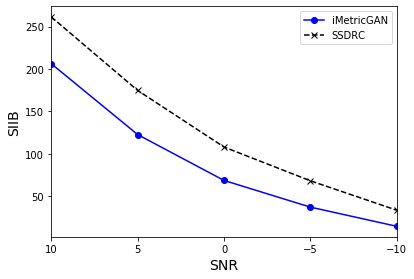

In [11]:
scores_imgan = calc_mean_siib_scores(siib_scores_imgan)
#scores_imgan2 = calc_mean_siib_scores(siib_scores_imgan2)
scores_ssdrc = calc_mean_siib_scores(siib_scores_ssdrc)

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
ax.plot(snrs, np.array(scores_imgan)[:, 1], 'bo-', label='iMetricGAN')
#plt.plot(snrs, np.array(scores_imgan2)[:, 1], 'bo-', label='iMetricGAN2')
plt.plot(snrs, np.array(scores_ssdrc)[:, 1], 'kx--', label='SSDRC')
plt.xlabel('SNR', fontsize=14)
plt.ylabel('SIIB', fontsize=14)
plt.legend()
plt.xlim([10, -10])
ax.set_xticks([10, 5, 0, -5, -10])
#fig.savefig(os.path.join(out_dir, 'ssdrc_vs_imgan.png'))

## make demo samples.

In [39]:
n_epoch = 3
imgan_dir = os.path.join(default.output_path, 'epoch' + str(n_epoch), 'Test_epoch' + str(n_epoch))
wav_imgan_paths = glob.glob(os.path.join(imgan_dir, '*.wav'))
wav_imgan_paths.sort()
siib_scores = []
for i, wav_imgan_path in enumerate(wav_imgan_paths, start=1):
    #print('\r' + '{}/{}'.format(i, len(wav_imgan_paths)), end="")
    
    # get information from the path.
    wav_basename = os.path.basename(wav_imgan_path)
    wav_id = wav_basename.split('_snr')[0] + '.wav'
    snr_str = wav_basename.split('_snr')[1].split('@')[0]
    snr = int(snr_str)
    
    # paths to the relevant files.
    imgan_dir = os.path.join(default.output_path, 'epoch' + str(n_epoch), 'Test_epoch' + str(n_epoch))
    wav_clean_path = os.path.join(per_snr_dir, 'test', 'clean', wav_id)
    wav_noise_path = os.path.join(per_snr_dir, 'test', 'noise'+snr_str, wav_id)
    wav_ssdrc_path = os.path.join(ssdrc_dir, wav_id)

    
#     print('{} (SNR:{})'.format(wav_id, snr))
#     print('clean: {} (exists: {})'.format(wav_clean_path, os.path.exists(wav_clean_path)))
#     print('noise: {} (exists: {})'.format(wav_noise_path, os.path.exists(wav_noise_path)))
#     print('imgan: {}'.format(wav_imgan_path))
#     print('ssdrc: {} (exists: {})'.format(wav_ssdrc_path, os.path.exists(wav_ssdrc_path)))

    # the name to be used for demo samples.
    wav_basename_out = 'ssdrc_vs_imgan_' + wav_id.replace('.wav', '_snr' + str(snr)) 
    
    # calculate if the intelligibility improved.
    siib_clean_score = read_SIIB(wav_clean_path, wav_noise_path, wav_clean_path)
    siib_imgan_score = read_SIIB(wav_clean_path, wav_noise_path, wav_imgan_path)
    siib_ssdrc_score = read_SIIB(wav_clean_path, wav_noise_path, wav_ssdrc_path)
    siib_scores.append([wav_id, snr, siib_clean_score, siib_imgan_score, siib_ssdrc_score])
    
    # if the SIIB is improved, added to the demo folder.
    if siib_clean_score < siib_imgan_score:
        print(wav_basename_out)
        print('SIIB clean: {}'.format(siib_clean_score))
        print('SIIB imgan: {}'.format(siib_imgan_score))
        print('SIIB ssdrc: {}'.format(siib_ssdrc_score))

        # clean
        shutil.copy(
            wav_clean_path,
            os.path.join(out_dir, wav_basename_out + '_clean.wav')
        )
        # imgan
        shutil.copy(
            wav_imgan_path,
            os.path.join(out_dir, wav_basename_out + '_imgan.wav')
        )
        # ssdrc
        shutil.copy(
            wav_ssdrc_path,
            os.path.join(out_dir, wav_basename_out + '_ssdrc.wav')
        )

        ## add noise.
        wav_clean = sp.load_wav(wav_clean_path)
        wav_imgan = sp.load_wav(wav_imgan_path)
        wav_ssdrc = sp.load_wav(wav_ssdrc_path)
        wav_noise = sp.load_wav(wav_noise_path)
        n_samples = min(len(wav_clean), len(wav_imgan), len(wav_ssdrc), len(wav_noise))

        # clean
        librosa.output.write_wav(
            os.path.join(out_dir, wav_basename_out + '_clean-noised.wav'), 
            wav_clean[:n_samples] + wav_noise[:n_samples], 
            sampling_frequency)    
        # imgan
        librosa.output.write_wav(
            os.path.join(out_dir, wav_basename_out + '_imgan-noised.wav'), 
            wav_imgan[:n_samples] + wav_noise[:n_samples], 
            sampling_frequency)
        # ssdrc
        librosa.output.write_wav(
            os.path.join(out_dir, wav_basename_out + '_ssdrc-noised.wav'), 
            wav_ssdrc[:n_samples] + wav_noise[:n_samples], 
            sampling_frequency)

# save SIIB scores.
df_siib_scores = pd.DataFrame(siib_scores, columns = ['filename', 'SNR', 'original', 'iMetricGAN', 'SSDRC'])
df_siib_scores['improvement'] = df_siib_scores['iMetricGAN']-df_siib_scores['SSDRC']
df_siib_scores.to_pickle(os.path.join(out_dir, 'df_siib_scores.pkl'))

ssdrc_vs_imgan_hikari-003_057_snr-5
SIIB clean: 42.81527825943192
SIIB imgan: 93.6560719482647
SIIB ssdrc: 86.82462944799104
ssdrc_vs_imgan_hikari-010_053_snr-10
SIIB clean: 19.431541131325517
SIIB imgan: 49.741544159279286
SIIB ssdrc: 35.26695680409776
ssdrc_vs_imgan_hikari-010_053_snr0
SIIB clean: 85.88463508358268
SIIB imgan: 129.03608051395815
SIIB ssdrc: 120.10979403180687
ssdrc_vs_imgan_hikari-010_053_snr10
SIIB clean: 195.0160648254173
SIIB imgan: 207.81237023811914
SIIB ssdrc: 238.19431987284844
ssdrc_vs_imgan_hikari-014_004_snr-10
SIIB clean: 14.03396062792244
SIIB imgan: 40.57228170127989
SIIB ssdrc: 36.07188317693125
ssdrc_vs_imgan_hikari-014_004_snr-5
SIIB clean: 38.575281180032036
SIIB imgan: 86.06283588810165
SIIB ssdrc: 75.59867079493625
ssdrc_vs_imgan_hikari-014_004_snr10
SIIB clean: 198.6229673966651
SIIB imgan: 253.95464975209123
SIIB ssdrc: 273.04967710632604
ssdrc_vs_imgan_hikari-014_004_snr5
SIIB clean: 138.5167809068165
SIIB imgan: 208.82620138146982
SIIB ssdrc: 2

In [42]:
df_siib_scores.sort_values('filename')

filename  SNR    original  iMetricGAN       SSDRC  improvement
0   hikari-003_057.wav   -5   42.815278   93.656072   86.824629     6.831443
1   hikari-010_053.wav  -10   19.431541   49.741544   35.266957    14.474587
2   hikari-010_053.wav    0   85.884635  129.036081  120.109794     8.926286
3   hikari-010_053.wav   10  195.016065  207.812370  238.194320   -30.381950
4   hikari-014_004.wav  -10   14.033961   40.572282   36.071883     4.500399
5   hikari-014_004.wav   -5   38.575281   86.062836   75.598671    10.464165
6   hikari-014_004.wav   10  198.622967  253.954650  273.049677   -19.095027
7   hikari-014_004.wav    5  138.516781  208.826201  206.928109     1.898092
8   hikari-015_046.wav  -10   13.864848   41.062608   29.824339    11.238269
9   hikari-019_108.wav   -5   46.416069   96.268167   80.484097    15.784070
10  hikari-020_008.wav   -5   33.483209   60.000216   55.563630     4.436586
11  hikari-020_008.wav    0   66.093895   97.575488   96.489175     1.086313
12  hikari-020_008.wav   10  145.199933  149.399400  173.702398   -24.302998
13  hikari-041_065.wav   -5   36.446786   47.578315   51.113515    -3.535200
14  hikari-060_019.wav  -10   17.213436   42.981942   36.790684     6.191258
15  hikari-060_019.wav   -5   36.454172   80.121263   67.277271    12.843992
16  hikari-060_019.wav    0   83.445773  140.953972  129.536769    11.417203
17  hikari-075_072.wav  -10   15.862216   45.102325   35.265309     9.837017
18  hikari-075_072.wav   -5   41.483424   88.974931   74.901262    14.073669
19  hikari-075_072.wav    5  152.048020  205.448960  202.139282     3.309678

In [46]:
wav_paths = glob.glob(os.path.join(out_dir, '*hikari-010_053*noised.wav'))
wav_paths.sort()
for wav_path in wav_paths:
    wav_basename = os.path.basename(wav_path).split('ssdrc_vs_imgan_')[1]
    print(wav_basename)
    dp.disp_wav_file(wav_path)

hikari-010_053_snr-10_clean-noised.wav


hikari-010_053_snr-10_imgan-noised.wav


hikari-010_053_snr-10_ssdrc-noised.wav


hikari-010_053_snr0_clean-noised.wav


hikari-010_053_snr0_imgan-noised.wav


hikari-010_053_snr0_ssdrc-noised.wav


hikari-010_053_snr10_clean-noised.wav


hikari-010_053_snr10_imgan-noised.wav


hikari-010_053_snr10_ssdrc-noised.wav
